In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from tensorflow.python.client import device_lib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # sklearn, train_test_split
import matplotlib.pyplot as plt # matplotlib, plt
from keras.utils.np_utils import to_categorical # categorical - one-hot-encoding

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# CNN libraries
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/sample_submission.csv


Using TensorFlow backend.


In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    print(local_device_protos)
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16411723189761572485
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7566620510372491473
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14909932405113340855
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15882446439
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1598791846061977439
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


['/device:GPU:0']

In [3]:
# import datasets 
print(os.listdir("../input"))
directory_train = "../input/train.csv"
directory_test = "../input/test.csv"

['test.csv', 'train.csv', 'sample_submission.csv']


## Loading the Testing Data Set

In [4]:
test_data = pd.read_csv(directory_test)
print(test_data.shape)
test_data.head(5)

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Loading the Training  Data Set

In [5]:
train_data = pd.read_csv(directory_train)
print(train_data.shape)
train_data.head(5)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Formatting the Labels

In [6]:
## Formatting the Labels
def format_label():
    return [train_data["label"], 
            train_data.drop(labels = ["label"],axis = 1)
           ]

# call format_label
y_train, x_train = format_label()
print(x_train.head(5), y_train.head(5))

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   pixel9    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0   

## Show some samples

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


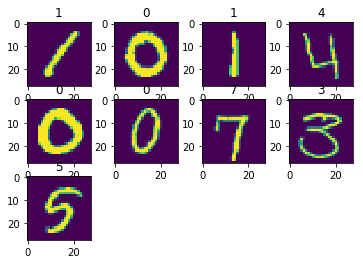

In [7]:
# Show some samples
# x_train dataset 
def show_figure():
    for index in range(0, 9):
        fig = x_train.iloc[index].as_matrix()
        fig = fig.reshape((28,28))
        plt.subplot(340 + (index + 1))
        plt.imshow(fig)
        plt.title(y_train[index])
        
# call show_figure      
show_figure()


In [8]:
def normalization():
    return [
            x_train / 255.0,
            test_data / 255.0
           ]
def reshape():
    return [
            x_train.values.reshape(-1,28, 28,1),
            test_data.values.reshape(-1,28,28,1)
           ]
def tensorflow_encoding():
    return to_categorical(y_train, num_classes = 10)

# call normalization
x_train, test_data = normalization()
print('x_train:',x_train.shape)
print('test:',test_data.shape)

# call reshape
print("------ Reshape ---------------")
x_train, test_data = reshape()
print('x_train:',x_train.shape)
print('test:',test_data.shape)

# call tensorflow label encoding
y_train = tensorflow_encoding()
print(y_train)

x_train: (42000, 784)
test: (28000, 784)
------ Reshape ---------------
x_train: (42000, 28, 28, 1)
test: (28000, 28, 28, 1)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## Separating the Data Set
Here, we need to separate data from training and test sets:
* For the tests, we use 10% of the data set;
* For training, we use 90% of the data set;

In [9]:
def separating_data():
    return train_test_split(x_train, 
                            y_train, 
                            test_size = 0.1, 
                            random_state = 42
                           )

x_train, x_validation, y_train, y_validation = separating_data()

## Modeling a tensorflow CNN
![Tensorflow CNN](https://miro.medium.com/max/700/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

In [10]:
activations = ['relu', 'softmax'] 
#Change the number of epochs for other results
# This may be interesting !
max_epochs = 2
model = Sequential()

model.add(Conv2D(filters = 32, 
                 kernel_size = (5,5),
                 padding = 'Same', 
                 activation = activations[0], 
                 input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, 
                 kernel_size = (5,5),
                 padding = 'Same', 
                 activation = activations[0]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation = activations[0]))
model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3),
                 padding = 'Same', 
                 activation = activations[0]))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = activations[0]))
model.add(Dropout(0.5))
model.add(Dense(10, activation = activations[1]))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=["accuracy"])

generator = ImageDataGenerator()

batches = generator.flow(x_train, 
                         y_train, 
                         batch_size=64)
batches_value = generator.flow(x_validation, 
                               y_validation, 
                               batch_size=64)

history = model.fit_generator(generator=batches, 
                              steps_per_epoch=batches.n, 
                              epochs=max_epochs, 
                              validation_data=batches_value, 
                              validation_steps=batches_value.n)

Epoch 1/2
35623/37800 [===========================>..] - ETA: 19s - loss: 0.0208 - acc: 0.9936

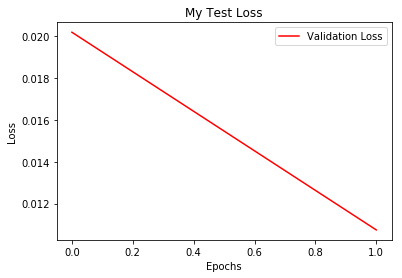

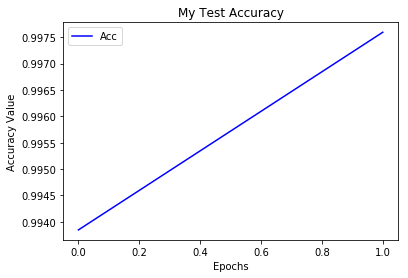

In [11]:
def show_loss():
    plt.plot(history.history['loss'], 
             color='red', 
             label='Validation Loss')
    plt.title("My Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
def show_acc_epochs():
    plt.plot(history.history['acc'],
             color='blue',
             label='Acc')
    plt.title("My Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy Value")
    plt.legend()
    plt.show()
    
# call plot loss
show_loss()
# call plt acc_epochs
show_acc_epochs()

In [12]:
# predict results and submit
results = model.predict(test_data)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),
                                  name = "ImageId"),
                        results],axis = 1)
submission.to_csv("submission.csv",index=False)

You can find more examples in Machine Learning on my Github: 
* Github Profile: https://github.com/vitorglemos/
* Github Machine Learning: https://github.com/vitorglemos/Machine-Learning-Algorithms